In [56]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pytorchtools import EarlyStopping
import math
from tqdm import tqdm

#### Numpy & Python Version 확인

In [57]:
import numpy as np
import platform

# NumPy 버전 확인
numpy_version = np.__version__

# Python 버전 확인
python_version = platform.python_version()

print(f"NumPy 버전: {numpy_version}")
print(f"Python 버전: {python_version}")

NumPy 버전: 1.26.4
Python 버전: 3.11.9


#### CUDA 사용 및 EarlyStopping 설정

In [58]:
torch.cuda.is_available()

False

In [59]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
early_stopping = EarlyStopping(patience = 5, verbose = True)

cpu


#### 모델 저장

In [60]:
def saveModel():
    torch.save(model.state_dict(), 'model_lstmautoencoder_ar1_latentvector.pt') # 모델의 학습된 매개변수 파일에 저장

#### 하이퍼 파라미터 설정

In [61]:
# 하이퍼파라미터 설정
length = 12            # 윈도우 사이즈 (생성할 시계열 데이터의 길이)
trainrun = 250       # 생성할 학습 데이터 시퀀스의 수 
validrun = 125         # 생성할 검증 데이터 시퀀스의 수 

# 시계열 데이터 생성을 위한 매개변수
# 자기상관계수 (phi값을 0.25, 0.5, 0.75, 0.95별로 생성)
phi1 = np.array([0.25, 0.5, 0.75, 0.95])

# 변화율 크기
psi1 = 0

# 공정의 수준 변화율 (delta)
de1 = 0

# 공정의 분산 변화율 (gamma)
ga = 1

#### 시계열 데이터 생성

In [62]:
np.random.seed(1)

# AR(1) 시계열 데이터 생성 함수
def ar(ar1, delta, gamma, psi, length, run):
    # 초기 설정
    y = np.zeros(shape=(run, length))                           # 생성될 시계열 데이터를 저장할 빈 배열을 초기화. 배열의 크기는 (생성할 데이터 시퀀스의 수, 각 시퀀스의 길이) 
    sigma = math.sqrt(1 / (1 - pow(ar1, 2)))                    # AR(1)모델의 표준 편차
    
    # 데이터 시퀀스 생성
    for j in range(0, run):                                     # 각 run 마다 랜덤 노이즈(e)를 정규분포에서 추출하여 시계열의 기본 노이즈 생성 (과적합 방지 차원)
        e = np.random.normal(loc=0, scale=1, size=length)       
        x = np.zeros(length)
        
        x[0] = e[0]                                             # x 배열 초기화하고, 첫 번째 시점의 값은 첫 번째 노이즈 값으로 설정 (시계열의 시작점에서 발생할 수 있는 임의성 반영 및 자기상관 구조 구현)

        # psi 시점 이전의 데이터 생성
        for i in range(1, psi):                                 # psi 시점 이전까지는 관리상태 데이터
            x[i] = ar1 * x[i - 1] + e[i]                        # 각 시점에서의 값은 이전 시점의 값에 자기상관 계수 ar1을 곱한 것과 현재 시점의 노이즈를 더한 값으로 설정
            
            # psi 시점 이후의 데이터 생성 및 변동성 적용
            if i >= psi:                                        # psi 시점 이후에는 각 에러 항에 gamma 값을 곱하여 에러 항의 변동성을 조절 
                e[i] = gamma * e[i]
                x[i] = ar1 * x[i - 1] + e[i] + delta * sigma    # delta(변동성 크기 조절하는 매개변수)를 통한 추가 변동성 적용
            
        # 최종 데이터 반환 (각 run에 대해 생성된 시계열 데이터를 저장)  
        y[j] = x

    return y


# 다양한 매개변수 조합에 대한 시계열 데이터 세트 생성
def totaldat(run,length):
    # 빈 데이터 배열 초기화
    y = np.zeros(shape=(len(phi1), run, length))
    # 매개변수 조합별 데이터 생성
    for i, phi in enumerate(phi1):
        y[i]= ar(phi, de1, ga, psi1, length, run)

    return y.reshape(run * len(phi1), length)                   # 생성된 데이터를 적절한 형태로 재배열


In [63]:
# 훈련용 시계열 데이터
# 데이터 생성 및 변형
train_x = totaldat(trainrun,length)                             # 훈련용 시계열 데이터 생성
train_x = train_x.reshape(trainrun*len(phi1),length)            

# 검증용 시계열 데이터
# 데이터 생성 및 변형
valid_x = totaldat(run = validrun, length = length)
valid_x = valid_x.reshape(validrun*len(phi1),length)

# PyTorch 텐서로 변환 및 장치 할당
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x = torch.FloatTensor(train_x).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)

# DataLoader 설정
trainloader = DataLoader(train_x, shuffle=True)                  # 데이터셋에서 미니배치 자동으로 생성 후 모델 학습 및 평가 시 배치 처리를 용이하게 함 (훈련에서는 데이터를 섞어 학습 과정에서의 일반화 능력 향상)
validloader = DataLoader(valid_x, shuffle=False)                # 학습 및 검증에서는 데이터 순서 유지

In [64]:
for data in trainloader:
    print(data.shape)
    break

torch.Size([1, 12])


In [65]:
len(trainloader)

1000

In [66]:
len(validloader)

500

In [67]:
train_x.shape[1]

12

#### LSTM Autoencoder 구조

In [68]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# LSTM Encoder 클래스 정의
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(LSTMEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.hidden_to_latent = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.hidden_to_latent(hidden[-1]) # 가장 마지막 layer의 hidden state 상태

# LSTM Decoder 클래스 정의
class LSTMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, seq_length):
        super(LSTMDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.outputs_to_data = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = self.latent_to_hidden(z).unsqueeze(0)
        repeated_z = z.repeat(self.seq_length, 1, 1).transpose(0, 1)
        lstm_out, _ = self.lstm(repeated_z)
        return self.outputs_to_data(lstm_out)

# 전체 LSTM 오토인코더 모델
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim=128, latent_dim=1):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = LSTMDecoder(latent_dim, hidden_dim, input_dim, seq_length)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# 모델 인스턴스 생성 및 설정
model = LSTMAutoencoder(input_dim=length, seq_length=length, hidden_dim=128, latent_dim=1)
model = model.to(device)

In [69]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

/opt/homebrew/anaconda3/envs/myproject3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 12])) that is different to the input size (torch.Size([1, 12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 0.0937, Validation Loss: 0.0918
Validation loss decreased (inf --> 0.091841).  Saving model ...
Epoch 2, Train Loss: 0.0925, Validation Loss: 0.0910
Validation loss decreased (0.091841 --> 0.090957).  Saving model ...
Epoch 3, Train Loss: 0.0918, Validation Loss: 0.0904
Validation loss decreased (0.090957 --> 0.090444).  Saving model ...
Epoch 4, Train Loss: 0.0914, Validation Loss: 0.0902
Validation loss decreased (0.090444 --> 0.090178).  Saving model ...
Epoch 5, Train Loss: 0.0912, Validation Loss: 0.0900
Validation loss decreased (0.090178 --> 0.090033).  Saving model ...
Epoch 6, Train Loss: 0.0911, Validation Loss: 0.0899
Validation loss decreased (0.090033 --> 0.089945).  Saving model ...
Epoch 7, Train Loss: 0.0910, Validation Loss: 0.0899
Validation loss decreased (0.089945 --> 0.089878).  Saving model ...
Epoch 8, Train Loss: 0.0909, Validation Loss: 0.0898
Validation loss decreased (0.089878 --> 0.089813).  Saving model ...
Epoch 9, Train Loss: 0.0908, 

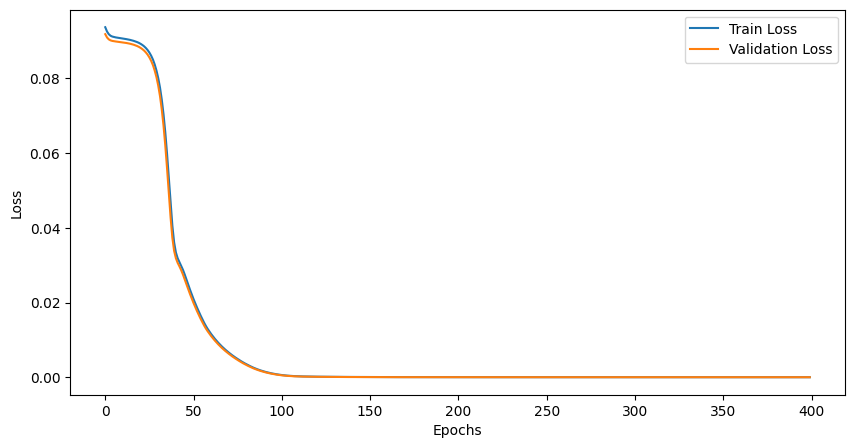

In [70]:
def training(epochs):
    loss_ = []
    valoss_ = []

    for epoch in range(epochs):
        running_train_loss = 0.0
        running_vall_loss = 0.0

        # Training process
        for data in trainloader:
            model.train()
            inputs = data                                                           # Assuming data is the input tensor
            inputs = inputs.to(device)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            train_loss = criterion(predicted_outputs, inputs)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = running_train_loss / len(trainloader)
        loss_.append(avg_train_loss)
        
        # Validation process
        with torch.no_grad():
            model.eval()
            for data in validloader:
                inputs = data
                inputs = inputs.to(device)
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, inputs)
                running_vall_loss += val_loss.item()

            avg_val_loss = running_vall_loss / len(validloader)
            valoss_.append(avg_val_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        # Early Stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Save model
    saveModel()
    return loss_, valoss_  # Return the collected loss values for training and validation

# Now when you call training, it will return the lists to be unpacked.
loss_, valoss_ = training(epochs=400)  # Set the appropriate number of epochs

# Loss visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_, label='Train Loss')
plt.plot(valoss_, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Batch size 32로 수정했을 때

In [7]:
np.random.seed(1)

# AR(1) 시계열 데이터 생성 함수
def ar(ar1, delta, gamma, psi, length, run):
    # 초기 설정
    y = np.zeros(shape=(run, length))                           # 생성될 시계열 데이터를 저장할 빈 배열을 초기화. 배열의 크기는 (생성할 데이터 시퀀스의 수, 각 시퀀스의 길이) 
    sigma = math.sqrt(1 / (1 - pow(ar1, 2)))                    # AR(1)모델의 표준 편차
    
    # 데이터 시퀀스 생성
    for j in range(0, run):                                     # 각 run 마다 랜덤 노이즈(e)를 정규분포에서 추출하여 시계열의 기본 노이즈 생성 (과적합 방지 차원)
        e = np.random.normal(loc=0, scale=1, size=length)       
        x = np.zeros(length)
        
        x[0] = e[0]                                             # x 배열 초기화하고, 첫 번째 시점의 값은 첫 번째 노이즈 값으로 설정 (시계열의 시작점에서 발생할 수 있는 임의성 반영 및 자기상관 구조 구현)

        # psi 시점 이전의 데이터 생성
        for i in range(1, psi):                                 # psi 시점 이전까지는 관리상태 데이터
            x[i] = ar1 * x[i - 1] + e[i]                        # 각 시점에서의 값은 이전 시점의 값에 자기상관 계수 ar1을 곱한 것과 현재 시점의 노이즈를 더한 값으로 설정
            
            # psi 시점 이후의 데이터 생성 및 변동성 적용
            if i >= psi:                                        # psi 시점 이후에는 각 에러 항에 gamma 값을 곱하여 에러 항의 변동성을 조절 
                e[i] = gamma * e[i]
                x[i] = ar1 * x[i - 1] + e[i] + delta * sigma    # delta(변동성 크기 조절하는 매개변수)를 통한 추가 변동성 적용
            
        # 최종 데이터 반환 (각 run에 대해 생성된 시계열 데이터를 저장)  
        y[j] = x

    return y


# 다양한 매개변수 조합에 대한 시계열 데이터 세트 생성
def totaldat(run,length):
    # 빈 데이터 배열 초기화
    y = np.zeros(shape=(len(phi1), run, length))
    # 매개변수 조합별 데이터 생성
    for i, phi in enumerate(phi1):
        y[i]= ar(phi, de1, ga, psi1, length, run)

    return y.reshape(run * len(phi1), length, 1)                   # 생성된 데이터를 적절한 형태로 재배열


In [24]:
# 훈련용 시계열 데이터
# 데이터 생성 및 변형
train_x = totaldat(trainrun,length)                             # 훈련용 시계열 데이터 생성

# 검증용 시계열 데이터
# 데이터 생성 및 변형
valid_x = totaldat(run = validrun, length = length)

# PyTorch 텐서로 변환 및 장치 할당
train_x = torch.FloatTensor(train_x).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)

# DataLoader 설정
trainloader = DataLoader(train_x, batch_size=32, shuffle=True)                  # 데이터셋에서 미니배치 자동으로 생성 후 모델 학습 및 평가 시 배치 처리를 용이하게 함 (훈련에서는 데이터를 섞어 학습 과정에서의 일반화 능력 향상)
validloader = DataLoader(valid_x, batch_size=32, shuffle=False)                # 학습 및 검증에서는 데이터 순서 유지

In [25]:
for data in trainloader:
    print(data.shape)
    break

torch.Size([32, 12, 1])


In [26]:
len(trainloader)

32

In [27]:
len(validloader)

16

In [28]:
train_x.shape[1]

12

In [29]:
# LSTM Encoder 클래스 정의
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(LSTMEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.hidden_to_latent = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.hidden_to_latent(hidden[-1])

# LSTM Decoder 클래스 정의
class LSTMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, seq_length):
        super(LSTMDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.outputs_to_data = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = self.latent_to_hidden(z).unsqueeze(1)
        repeated_z = z.repeat(1, self.seq_length, 1)
        lstm_out, _ = self.lstm(repeated_z)
        return self.outputs_to_data(lstm_out)

# 전체 LSTM 오토인코더 모델
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim=128, latent_dim=1):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = LSTMDecoder(latent_dim, hidden_dim, input_dim, seq_length)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# 모델 인스턴스 생성 및 설정
model = LSTMAutoencoder(input_dim=1, seq_length=12, hidden_dim=128, latent_dim=1)
model = model.to(device)

In [30]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)

Epoch 1, Train Loss: 0.0920, Validation Loss: 0.0839
Validation loss decreased (inf --> 0.083897).  Saving model ...
Epoch 2, Train Loss: 0.0915, Validation Loss: 0.0834
Validation loss decreased (0.083897 --> 0.083432).  Saving model ...
Epoch 3, Train Loss: 0.0913, Validation Loss: 0.0830
Validation loss decreased (0.083432 --> 0.083025).  Saving model ...
Epoch 4, Train Loss: 0.0907, Validation Loss: 0.0827
Validation loss decreased (0.083025 --> 0.082670).  Saving model ...
Epoch 5, Train Loss: 0.0911, Validation Loss: 0.0824
Validation loss decreased (0.082670 --> 0.082363).  Saving model ...
Epoch 6, Train Loss: 0.0907, Validation Loss: 0.0821
Validation loss decreased (0.082363 --> 0.082100).  Saving model ...
Epoch 7, Train Loss: 0.0893, Validation Loss: 0.0819
Validation loss decreased (0.082100 --> 0.081872).  Saving model ...
Epoch 8, Train Loss: 0.0907, Validation Loss: 0.0817
Validation loss decreased (0.081872 --> 0.081682).  Saving model ...
Epoch 9, Train Loss: 0.0899, 

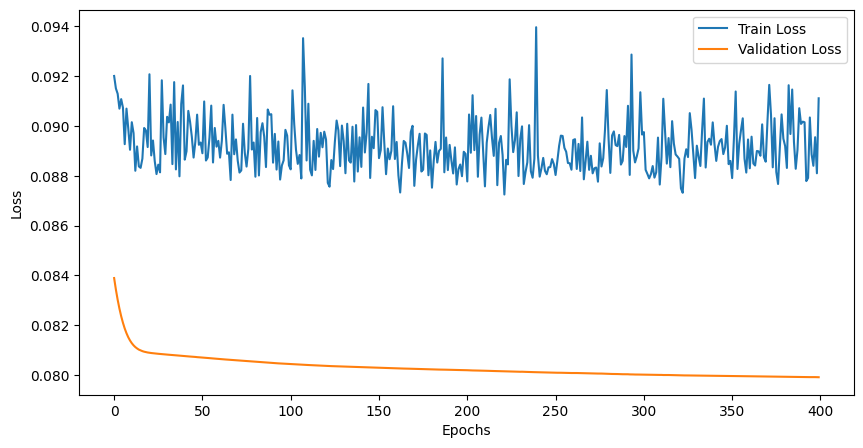

In [31]:
# 학습 함수 정의
def training(epochs):
    loss_ = []
    valoss_ = []

    for epoch in range(epochs):
        running_train_loss = 0.0
        running_vall_loss = 0.0

        # Training process
        for data in trainloader:
            model.train()
            inputs = data  # Assuming data is the input tensor
            inputs = inputs.to(device)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            train_loss = criterion(predicted_outputs, inputs)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = running_train_loss / len(trainloader)
        loss_.append(avg_train_loss)
        
        # Validation process
        with torch.no_grad():
            model.eval()
            for data in validloader:
                inputs = data
                inputs = inputs.to(device)
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, inputs)
                running_vall_loss += val_loss.item()

            avg_val_loss = running_vall_loss / len(validloader)
            valoss_.append(avg_val_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        # Early Stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Save model
    saveModel()
    return loss_, valoss_  # Return the collected loss values for training and validation

# Now when you call training, it will return the lists to be unpacked.
loss_, valoss_ = training(epochs=400)  # Set the appropriate number of epochs

# Loss visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_, label='Train Loss')
plt.plot(valoss_, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### 모델 불러오기

In [45]:
model.load_state_dict(torch.load('model_lstmautoencoder_ar1_latentvector.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

#### 학습 데이터로부터 잠재 벡터 추출

In [71]:
latent_vectors = []
model.eval()
with torch.no_grad():
    for data in trainloader:
        inputs = data.to(device)
        latent_vec = model.encoder(inputs)
        latent_vectors.append(latent_vec.cpu().numpy())
latent_vectors = np.concatenate(latent_vectors, axis=0)
latent_vectors

array([-6.30517527e-02,  1.18449889e-01,  1.64976522e-01, -1.84398577e-01,
        5.99350929e-02, -2.80030310e-01, -3.21613610e-01, -1.10241242e-01,
       -6.19519234e-01,  5.25978059e-02, -7.66090080e-02, -1.16627157e-01,
       -4.20927778e-02, -5.70401669e-01,  1.73916325e-01, -9.93839875e-02,
       -1.40075073e-01, -3.65174413e-02,  5.22415519e-01,  4.77909118e-01,
        5.17535925e-01, -1.23669349e-01,  8.11071843e-02, -5.85202396e-01,
        1.79260045e-01,  2.70411164e-01, -2.20219679e-02, -2.72248119e-01,
       -3.32175046e-02,  3.54134031e-02, -2.78884228e-02, -6.02124035e-01,
       -4.07003671e-01, -3.20616812e-02, -1.76616609e-01, -6.56359375e-01,
       -3.64775121e-01, -2.34756932e-01,  7.87998959e-02, -1.07638221e-02,
       -2.21572354e-01, -2.66086370e-01, -3.75656784e-01, -7.75687397e-02,
        1.25576630e-01, -1.30884096e-01, -3.32816541e-01,  6.41902387e-01,
       -7.36239702e-02, -2.01365143e-01,  3.16500664e-01, -3.62974882e-01,
       -3.19193304e-02, -

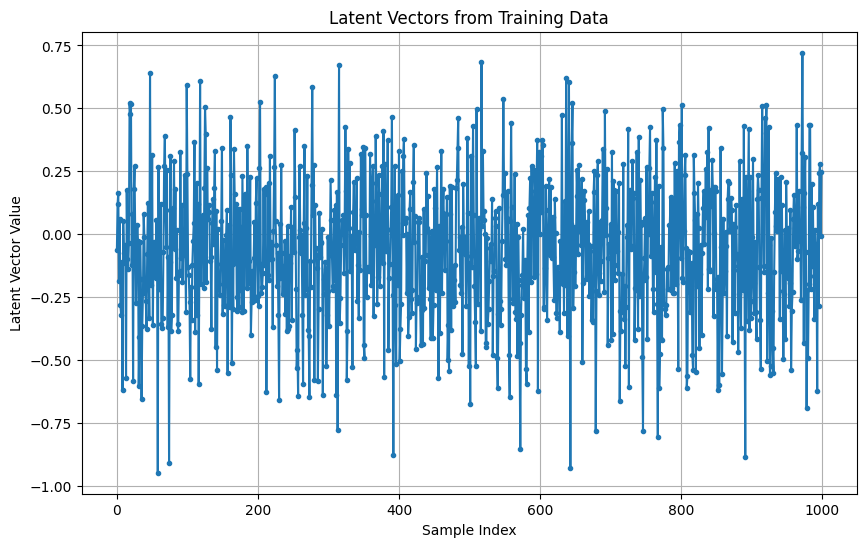

In [72]:
plt.figure(figsize=(10,6))
plt.plot(latent_vectors, 'o-', markersize=3)
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.grid(True)
plt.show()

#### 학습 데이터로부터 잠재 벡터의 평균 계산

In [73]:
mean_latent_vector = np.mean(latent_vectors)
mean_latent_vector

-0.06635497

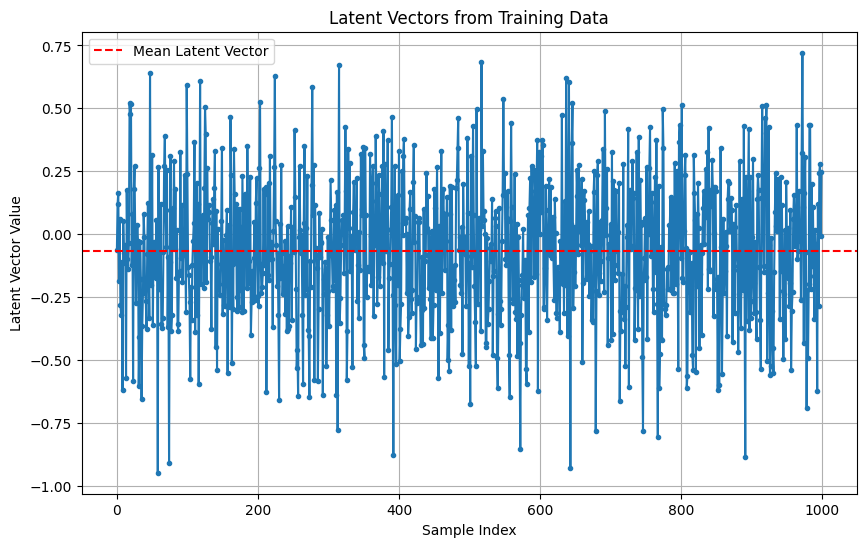

In [74]:
plt.figure(figsize=(10,6))
plt.plot(latent_vectors, 'o-', markersize=3)
plt.axhline(y=mean_latent_vector, color='r', linestyle='--', label='Mean Latent Vector')
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
centering_mean = np.abs(latent_vectors - mean_latent_vector)
centering_mean

array([3.30321491e-03, 1.84804857e-01, 2.31331497e-01, 1.18043609e-01,
       1.26290053e-01, 2.13675350e-01, 2.55258650e-01, 4.38862741e-02,
       5.53164244e-01, 1.18952774e-01, 1.02540404e-02, 5.02721891e-02,
       2.42621899e-02, 5.04046679e-01, 2.40271300e-01, 3.30290198e-02,
       7.37201050e-02, 2.98375264e-02, 5.88770509e-01, 5.44264078e-01,
       5.83890915e-01, 5.73143810e-02, 1.47462159e-01, 5.18847406e-01,
       2.45615005e-01, 3.36766124e-01, 4.43329997e-02, 2.05893159e-01,
       3.31374630e-02, 1.01768374e-01, 3.84665430e-02, 5.35769045e-01,
       3.40648711e-01, 3.42932865e-02, 1.10261641e-01, 5.90004385e-01,
       2.98420161e-01, 1.68401957e-01, 1.45154864e-01, 5.55911437e-02,
       1.55217379e-01, 1.99731410e-01, 3.09301823e-01, 1.12137720e-02,
       1.91931605e-01, 6.45291284e-02, 2.66461581e-01, 7.08257377e-01,
       7.26900250e-03, 1.35010183e-01, 3.82855624e-01, 2.96619922e-01,
       3.44356373e-02, 9.86670628e-02, 6.77421689e-04, 1.08298726e-01,
      

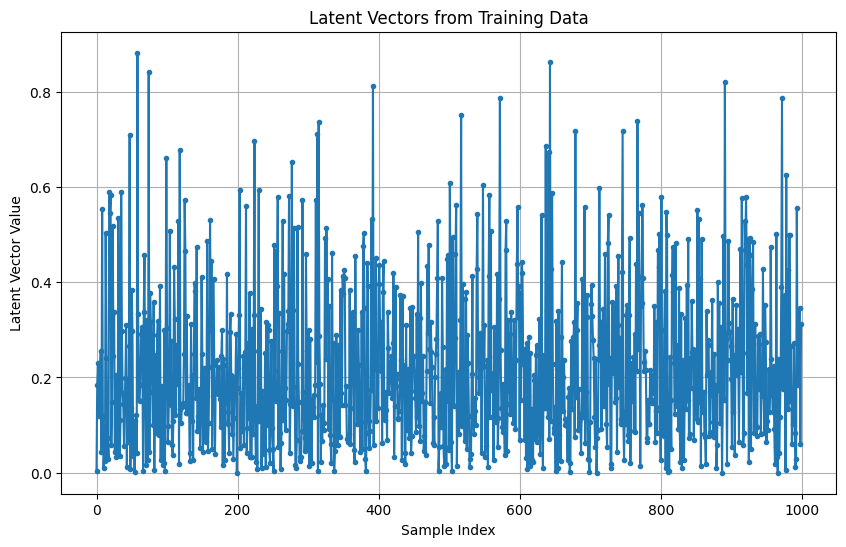

In [76]:
plt.figure(figsize=(10,6))
plt.plot(centering_mean, 'o-', markersize=3)
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.grid(True)
plt.show()

#### 학습 데이터로부터 잠재 벡터의 중앙값 계산

In [77]:
median_latent_vector = np.median(latent_vectors)
median_latent_vector

-0.06487298

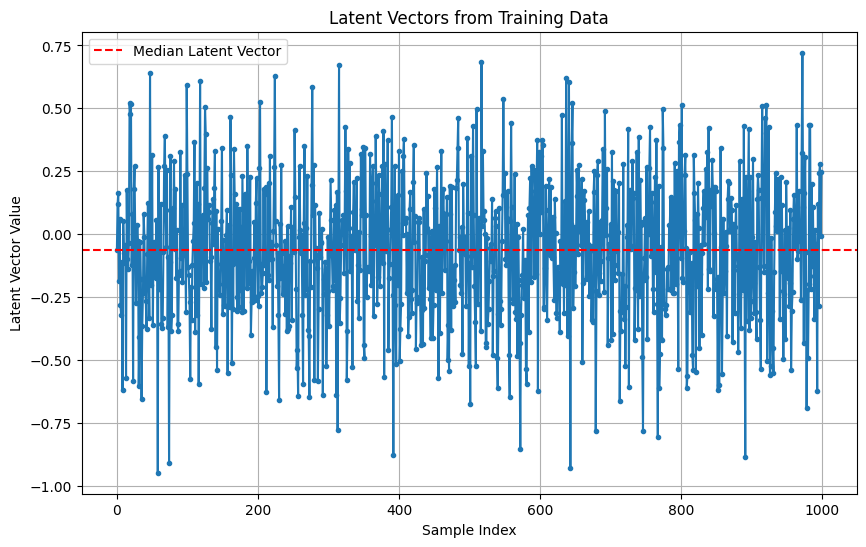

In [78]:
plt.figure(figsize=(10,6))
plt.plot(latent_vectors, 'o-', markersize=3)
plt.axhline(y=median_latent_vector, color='r', linestyle='--', label='Median Latent Vector')
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
centering_median = np.abs(latent_vectors - median_latent_vector)
centering_median

array([0.00182123, 0.18332288, 0.2298495 , 0.1195256 , 0.12480807,
       0.21515733, 0.25674063, 0.04536826, 0.55464625, 0.11747079,
       0.01173603, 0.05175418, 0.0227802 , 0.5055287 , 0.2387893 ,
       0.03451101, 0.07520209, 0.02835554, 0.5872885 , 0.54278207,
       0.5824089 , 0.05879637, 0.14598016, 0.5203294 , 0.24413303,
       0.33528414, 0.04285101, 0.20737514, 0.03165548, 0.10028638,
       0.03698456, 0.53725106, 0.3421307 , 0.0328113 , 0.11174363,
       0.5914864 , 0.29990214, 0.16988395, 0.14367288, 0.05410916,
       0.15669937, 0.20121339, 0.3107838 , 0.01269576, 0.19044961,
       0.06601112, 0.26794356, 0.70677537, 0.00875099, 0.13649216,
       0.38137364, 0.2981019 , 0.03295365, 0.10014905, 0.00215941,
       0.10978071, 0.11942179, 0.04234701, 0.88330036, 0.3321181 ,
       0.15445098, 0.15121295, 0.18348433, 0.2919312 , 0.30660653,
       0.2690056 , 0.00591036, 0.33569947, 0.45612428, 0.16261536,
       0.01573248, 0.31976065, 0.3034905 , 0.02737258, 0.84375

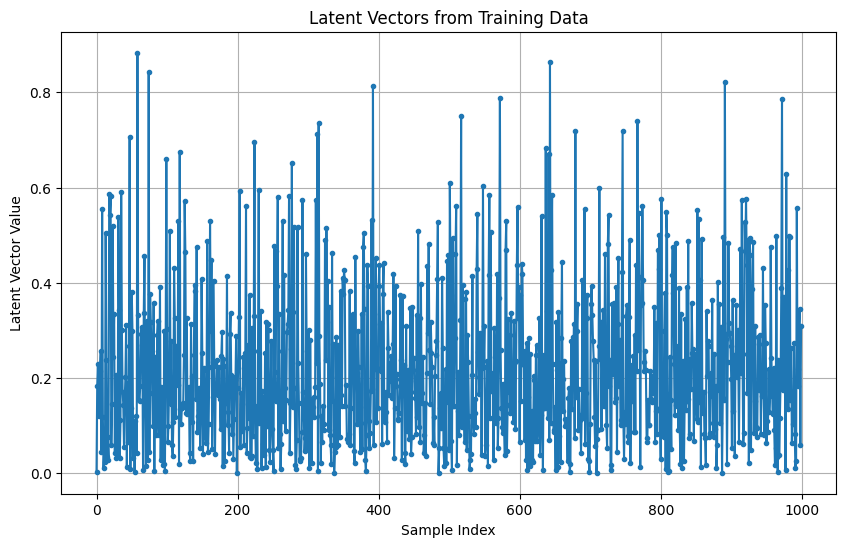

In [80]:
plt.figure(figsize=(10,6))
plt.plot(centering_median, 'o-', markersize=3)
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.grid(True)
plt.show()

#### Batch size를 32로 수정할 때

In [32]:
latent_vectors = []
model.eval()
with torch.no_grad():
    for data in trainloader:
        inputs = data.to(device)
        latent_vec = model.encoder(inputs)
        latent_vectors.append(latent_vec.cpu().numpy())
latent_vectors = np.concatenate(latent_vectors, axis=0)
latent_vectors

array([[-0.18882608],
       [-0.1872689 ],
       [-0.18649627],
       [-0.19045189],
       [-0.18923506],
       [-0.18626562],
       [-0.1885781 ],
       [-0.18814802],
       [-0.18618801],
       [-0.18857476],
       [-0.18817103],
       [-0.18831441],
       [-0.18570279],
       [-0.1900436 ],
       [-0.18576695],
       [-0.18745054],
       [-0.18755196],
       [-0.18682748],
       [-0.18694007],
       [-0.18844229],
       [-0.18733838],
       [-0.18736032],
       [-0.1880835 ],
       [-0.18719901],
       [-0.18862706],
       [-0.19000563],
       [-0.18831474],
       [-0.18740346],
       [-0.18945089],
       [-0.1891416 ],
       [-0.18799607],
       [-0.18884715],
       [-0.18658732],
       [-0.18785779],
       [-0.18892427],
       [-0.18893233],
       [-0.1878483 ],
       [-0.1851554 ],
       [-0.18597114],
       [-0.1864841 ],
       [-0.18632278],
       [-0.18805674],
       [-0.19135964],
       [-0.18779229],
       [-0.18855304],
       [-0

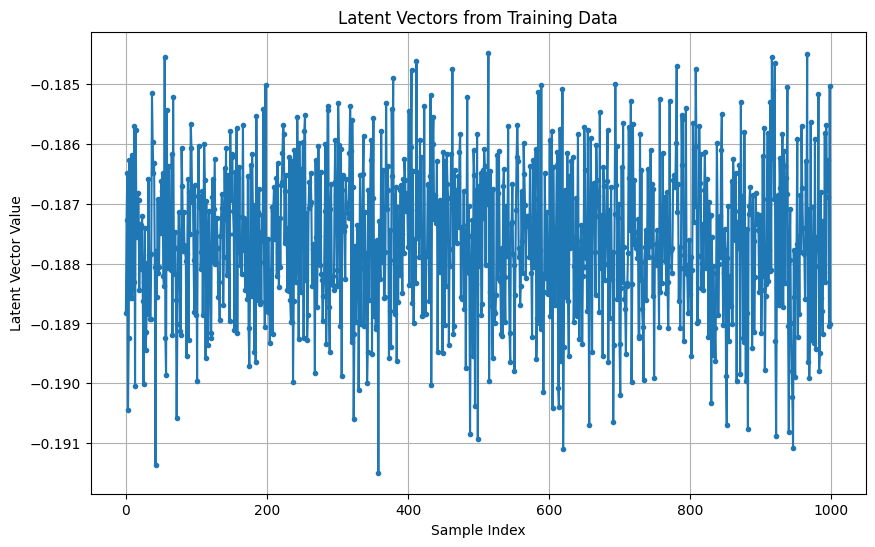

In [33]:
plt.figure(figsize=(10,6))
plt.plot(latent_vectors, 'o-', markersize=3)
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.grid(True)
plt.show()

##### 학습 데이터로부터 잠재 벡터의 평균 계산

In [34]:
mean_latent_vector = np.mean(latent_vectors)
mean_latent_vector

-0.18761738

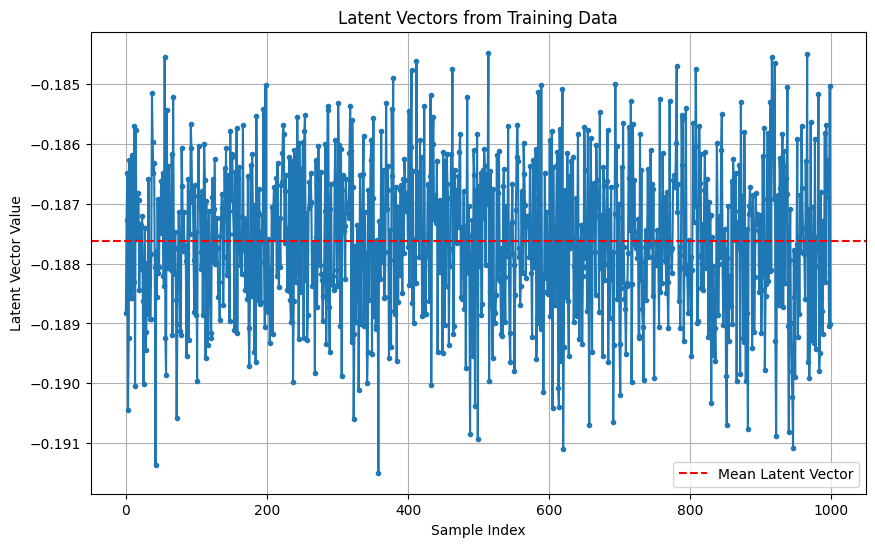

In [35]:
plt.figure(figsize=(10,6))
plt.plot(latent_vectors, 'o-', markersize=3)
plt.axhline(y=mean_latent_vector, color='r', linestyle='--', label='Mean Latent Vector')
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
centering_mean = np.abs(latent_vectors - mean_latent_vector)
centering_mean

array([[1.20870769e-03],
       [3.48478556e-04],
       [1.12110376e-03],
       [2.83451378e-03],
       [1.61768496e-03],
       [1.35175884e-03],
       [9.60722566e-04],
       [5.30645251e-04],
       [1.42936409e-03],
       [9.57384706e-04],
       [5.53652644e-04],
       [6.97031617e-04],
       [1.91459060e-03],
       [2.42622197e-03],
       [1.85042620e-03],
       [1.66833401e-04],
       [6.54160976e-05],
       [7.89895654e-04],
       [6.77302480e-04],
       [8.24913383e-04],
       [2.78994441e-04],
       [2.57059932e-04],
       [4.66123223e-04],
       [4.18365002e-04],
       [1.00968778e-03],
       [2.38825381e-03],
       [6.97359443e-04],
       [2.13921070e-04],
       [1.83351338e-03],
       [1.52422488e-03],
       [3.78698111e-04],
       [1.22977793e-03],
       [1.03005767e-03],
       [2.40415335e-04],
       [1.30689144e-03],
       [1.31495297e-03],
       [2.30923295e-04],
       [2.46196985e-03],
       [1.64623559e-03],
       [1.13327801e-03],


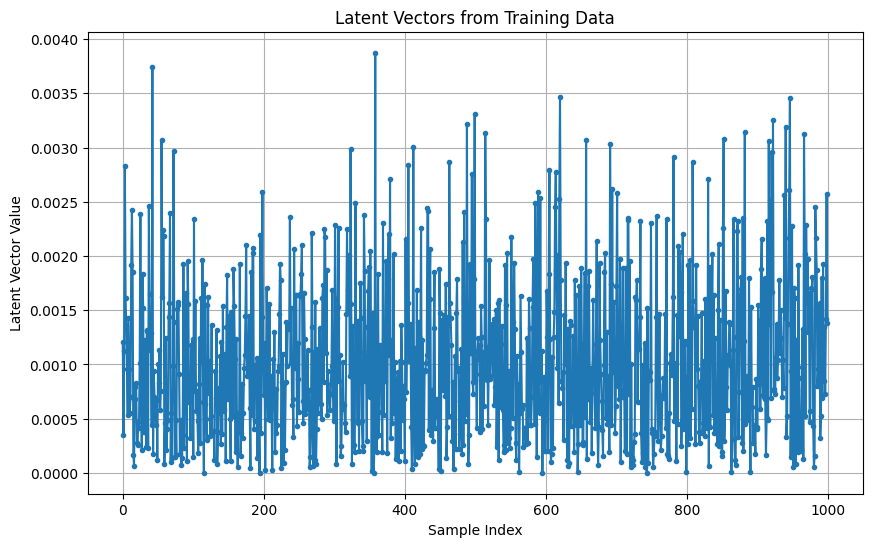

In [37]:
plt.figure(figsize=(10,6))
plt.plot(centering_mean, 'o-', markersize=3)
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.grid(True)
plt.show()

##### 학습 데이터로부터 잠재 벡터의 중앙값 계산

In [38]:
median_latent_vector = np.median(latent_vectors)
median_latent_vector

-0.187627

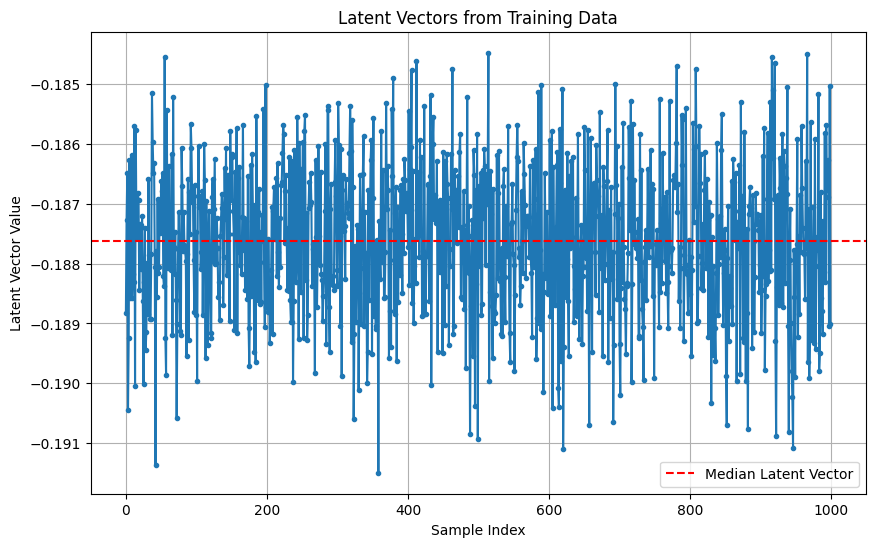

In [39]:
plt.figure(figsize=(10,6))
plt.plot(latent_vectors, 'o-', markersize=3)
plt.axhline(y=median_latent_vector, color='r', linestyle='--', label='Median Latent Vector')
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
centering_median = np.abs(latent_vectors - median_latent_vector)
centering_median

array([[1.19908154e-03],
       [3.58104706e-04],
       [1.13072991e-03],
       [2.82488763e-03],
       [1.60805881e-03],
       [1.36138499e-03],
       [9.51096416e-04],
       [5.21019101e-04],
       [1.43899024e-03],
       [9.47758555e-04],
       [5.44026494e-04],
       [6.87405467e-04],
       [1.92421675e-03],
       [2.41659582e-03],
       [1.86005235e-03],
       [1.76459551e-04],
       [7.50422478e-05],
       [7.99521804e-04],
       [6.86928630e-04],
       [8.15287232e-04],
       [2.88620591e-04],
       [2.66686082e-04],
       [4.56497073e-04],
       [4.27991152e-04],
       [1.00006163e-03],
       [2.37862766e-03],
       [6.87733293e-04],
       [2.23547220e-04],
       [1.82388723e-03],
       [1.51459873e-03],
       [3.69071960e-04],
       [1.22015178e-03],
       [1.03968382e-03],
       [2.30789185e-04],
       [1.29726529e-03],
       [1.30532682e-03],
       [2.21297145e-04],
       [2.47159600e-03],
       [1.65586174e-03],
       [1.14290416e-03],


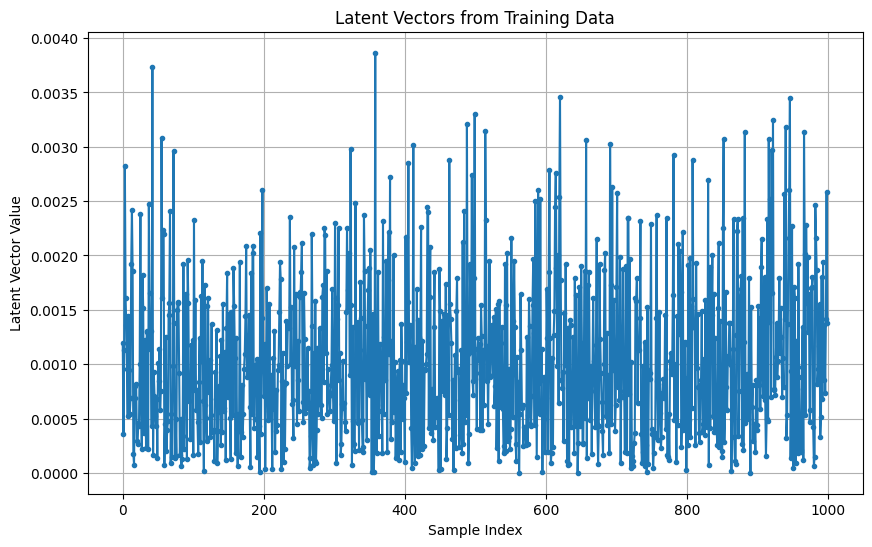

In [41]:
plt.figure(figsize=(10,6))
plt.plot(centering_median, 'o-', markersize=3)
plt.xlabel('Sample Index')
plt.ylabel('Latent Vector Value')
plt.title('Latent Vectors from Training Data')
plt.grid(True)
plt.show()

#### ARL0 구하기

In [81]:
np.random.seed(1)

l = 12

# 관리상태 / 이상상태 데이터 생성 함수
def argen(ar, psi, delta,gamma, length) :

    e = np.random.normal(loc=0, scale = 1,size = length)
    sigma = math.sqrt(1 / (1 - pow(ar, 2)))
    x = np.array(np.repeat(0, length), dtype= np.float64)
    x[0] = e[0]
    z = np.array(np.repeat(0, length), dtype=np.float64)

    for i in range(1, psi):
        x[i] = ar * x[i-1] + e[i]
        z[i] = x[i]
    for i in range(psi,len(x)):
        x[i] = ar * x[i - 1] + gamma*e[i]
        z[i] = x[i]
    for i in range(psi,len(z)):
        z[i] = z[i] + delta * sigma

    return z

In [82]:
def arl(ar,delta,gamma, run, length,cl) :
    rl = np.array([], dtype=np.float64)

    for i in tqdm(range(run)) :
        y = argen(ar=ar, psi=l-1, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l))
        for j in range(length-l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                latent_vec = model.encoder(input)
                latent_vec_value = latent_vec.cpu().numpy()[0]

                if np.abs(latent_vec_value - median_latent_vector) > cl:
                    a = np.array([j + 1])
                    break
                elif j == len(x) - 1:
                    a = len(x)

            rl = np.append(rl,a)

    arl = np.mean(rl)
    return arl

#### 그래프 그리는 ARL 구하기

In [87]:
def arl(ar,delta,gamma, run, length,cl) :
    rl = np.array([], dtype=np.float64)
    all_latent_vecs = []

    for i in tqdm(range(run)) :
        y = argen(ar=ar, psi=l-1, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l))
        for j in range(length-l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                latent_vec = model.encoder(input)
                latent_vec_value = latent_vec.cpu().numpy()[0]
                
                all_latent_vecs.append(latent_vec_value)
                
                
                if np.abs(latent_vec_value - median_latent_vector) > cl:
                    a = np.array([j + 1])
                    break
                elif j == len(x) - 1:
                    a = len(x)

            rl = np.append(rl,a)

    arl = np.mean(rl)
    
    # 그래프 그리기
    all_latent_vecs = np.array(all_latent_vecs)
    centering_median = np.abs(all_latent_vecs - median_latent_vector)
    plt.figure(figsize=(10, 6))
    plt.plot(centering_median, 'o', markersize=1)
    plt.axhline(y=cl, color='r', linestyle='--', label='Control Limit')
    plt.xlabel('Sample Index')
    plt.ylabel('Centered Latent Vector Value')
    plt.title('Centered Latent Vectors from ARL Calculation')
    plt.grid(True)
    plt.legend()
    plt.show()
    return arl

#### ARL1 구하기

In [88]:
def arl1(ar,run,length,cl):
    a5 = arl(ar, 0.5, 1, run, length, cl)
    a1 = arl(ar, 1, 1, run, length, cl)
    a2 = arl(ar, 2, 1, run, length, cl)
    a3 = arl(ar, 3, 1, run, length, cl)
    b5 = arl(ar, 0.5, 1.5,run, length, cl)
    b1 = arl(ar, 1, 1.5, run, length, cl)
    b2 = arl(ar, 2, 1.5, run, length, cl)
    b3 = arl(ar, 3, 1, run, length, cl)
    c1 = arl(ar, 0, 1.5, run, length, cl)
    c2 = arl(ar, 0, 2, run, length, cl)
    c3 = arl(ar, 0, 3, run, length, cl)
    print(f'0.5: {a5}, 1:{a1},2:{a2},3:{a3}')
    print(f'0.5:{b5},1:{b1},2:{b2},3:{b3}')
    print(f'1.5:{c1},2:{c2},3:{c3}')

#### phi = 0 일 때

##### ARL0 (threshold 임의추정)

In [59]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.4555)

100%|██████████| 10000/10000 [00:17<00:00, 572.25it/s]


12.7139

100%|██████████| 10000/10000 [00:17<00:00, 580.69it/s]


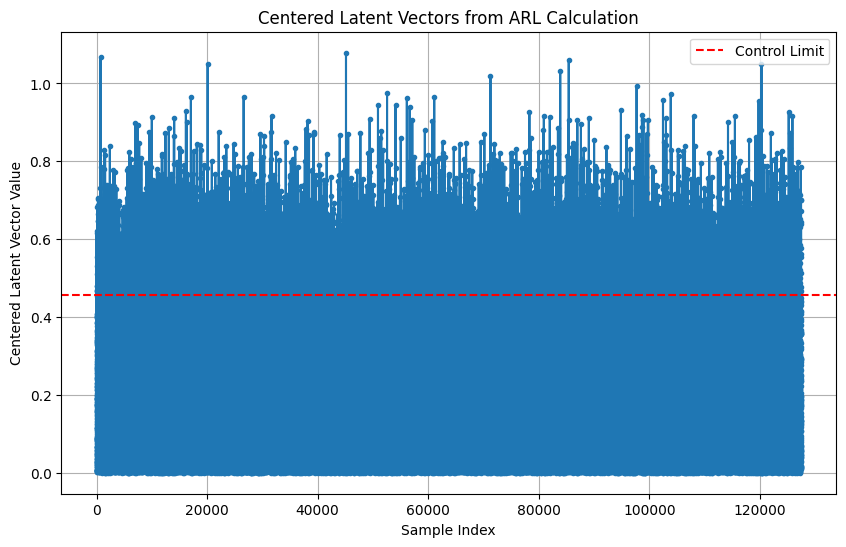

12.745

In [64]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.4555)

100%|██████████| 10000/10000 [00:16<00:00, 615.07it/s]


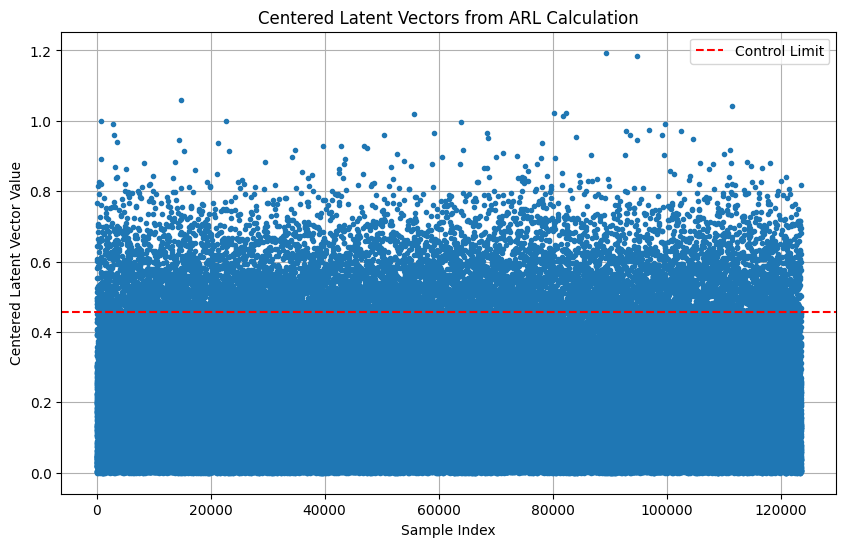

12.3571

In [85]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.4555)

100%|██████████| 10000/10000 [00:16<00:00, 600.92it/s]


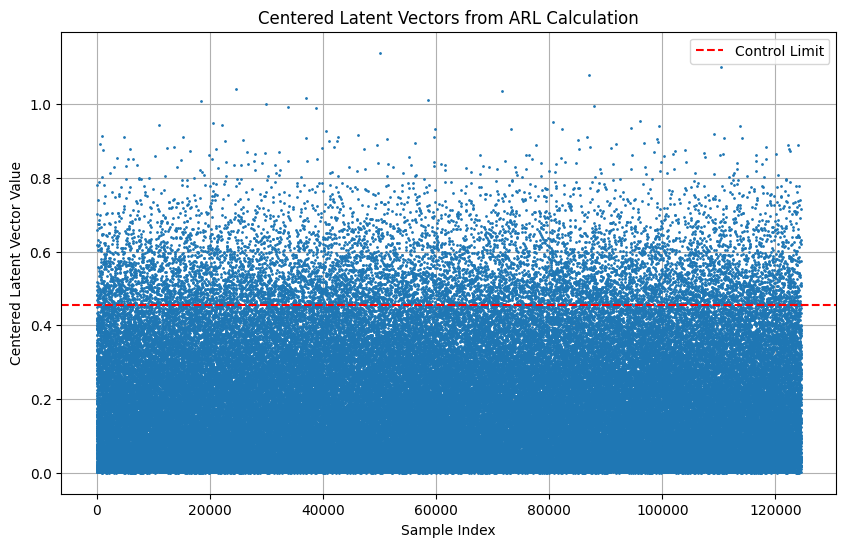

12.4531

In [89]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.4555)

In [60]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.77)

100%|██████████| 10000/10000 [05:01<00:00, 33.18it/s]


365.9453

100%|██████████| 10000/10000 [05:08<00:00, 32.46it/s]


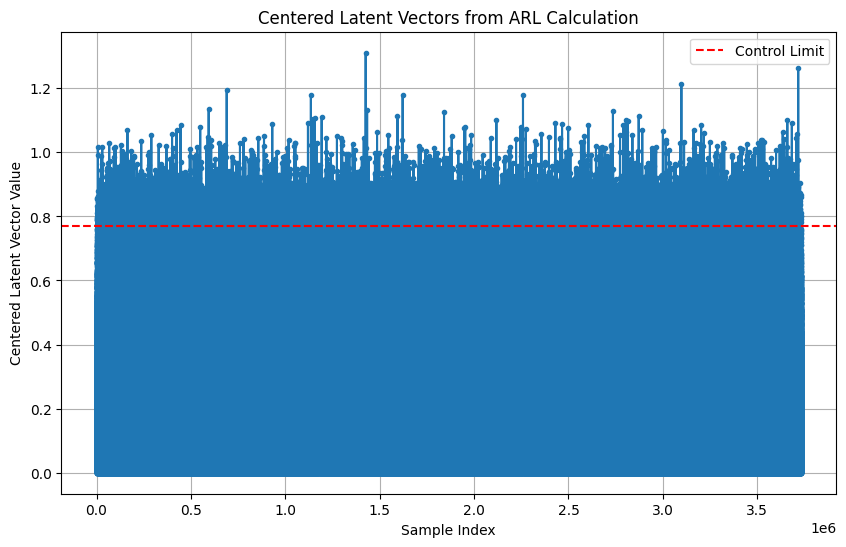

373.1853

In [65]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.77)

100%|██████████| 10000/10000 [04:36<00:00, 36.14it/s]


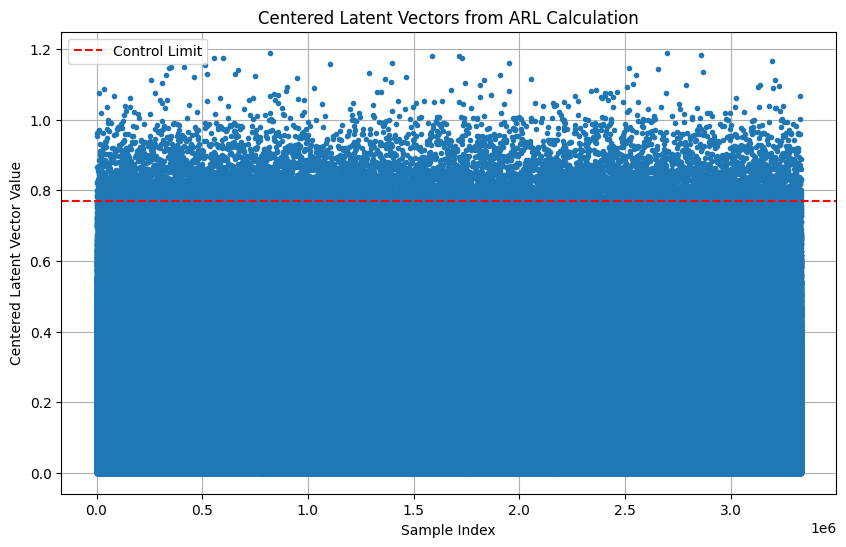

333.2976

In [86]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 10000, length = 1000, cl = 0.77)

##### ARL1

In [61]:
arl1(ar = 0.25, run = 10000, length = 1000, cl = 0.77)

100%|██████████| 10000/10000 [00:19<00:00, 503.98it/s]

0.5: 230.6855, 1:118.1213,2:50.3685,3:33.7155
0.5:34.3093,1:29.0478,2:22.2623,3:33.2128
1.5:37.7208,2:20.7099,3:15.5176


#### Batch size가 32일 때

##### ARL0 구하기

In [42]:
np.random.seed(1)

l = 12

# 관리상태 / 이상상태 데이터 생성 함수
def argen(ar, psi, delta,gamma, length) :

    e = np.random.normal(loc=0, scale = 1,size = length)
    sigma = math.sqrt(1 / (1 - pow(ar, 2)))
    x = np.array(np.repeat(0, length), dtype= np.float64)
    x[0] = e[0]
    z = np.array(np.repeat(0, length), dtype=np.float64)

    for i in range(1, psi):
        x[i] = ar * x[i-1] + e[i]
        z[i] = x[i]
    for i in range(psi,len(x)):
        x[i] = ar * x[i - 1] + gamma*e[i]
        z[i] = x[i]
    for i in range(psi,len(z)):
        z[i] = z[i] + delta * sigma

    return z

In [52]:
def arl(ar,delta,gamma, run, length,cl) :
    rl = np.array([], dtype=np.float64)
    all_latent_vecs = []

    for i in tqdm(range(run)) :
        y = argen(ar=ar, psi=l-1, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros((length-l, l, 1))
        for j in range(length-l):
            x[j, :, 0] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                latent_vec = model.encoder(input)
                latent_vec_value = latent_vec.cpu().numpy()[0]
                
                all_latent_vecs.append(latent_vec_value)
                
                
                if np.abs(latent_vec_value - median_latent_vector) > cl:
                    a = np.array([j + 1])
                    break
                elif j == len(x) - 1:
                    a = len(x)

            rl = np.append(rl,a)

    arl = np.mean(rl)
    
    # 그래프 그리기
    all_latent_vecs = np.array(all_latent_vecs)
    centering_median = np.abs(all_latent_vecs - median_latent_vector)
    plt.figure(figsize=(10, 6))
    plt.plot(centering_median, 'o-', markersize=3)
    plt.axhline(y=cl, color='r', linestyle='--', label='Control Limit')
    plt.xlabel('Sample Index')
    plt.ylabel('Centered Latent Vector Value')
    plt.title('Centered Latent Vectors from ARL Calculation')
    plt.grid(True)
    plt.legend()
    plt.show()
    return arl

##### ARL1 구하기

In [53]:
def arl1(ar,run,length,cl):
    a5 = arl(ar, 0.5, 1, run, length, cl)
    a1 = arl(ar, 1, 1, run, length, cl)
    a2 = arl(ar, 2, 1, run, length, cl)
    a3 = arl(ar, 3, 1, run, length, cl)
    b5 = arl(ar, 0.5, 1.5,run, length, cl)
    b1 = arl(ar, 1, 1.5, run, length, cl)
    b2 = arl(ar, 2, 1.5, run, length, cl)
    b3 = arl(ar, 3, 1, run, length, cl)
    c1 = arl(ar, 0, 1.5, run, length, cl)
    c2 = arl(ar, 0, 2, run, length, cl)
    c3 = arl(ar, 0, 3, run, length, cl)
    print(f'0.5: {a5}, 1:{a1},2:{a2},3:{a3}')
    print(f'0.5:{b5},1:{b1},2:{b2},3:{b3}')
    print(f'1.5:{c1},2:{c2},3:{c3}')

##### phi = 0 일 때

##### ARL0 (threshold 임의추정)

100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s] 


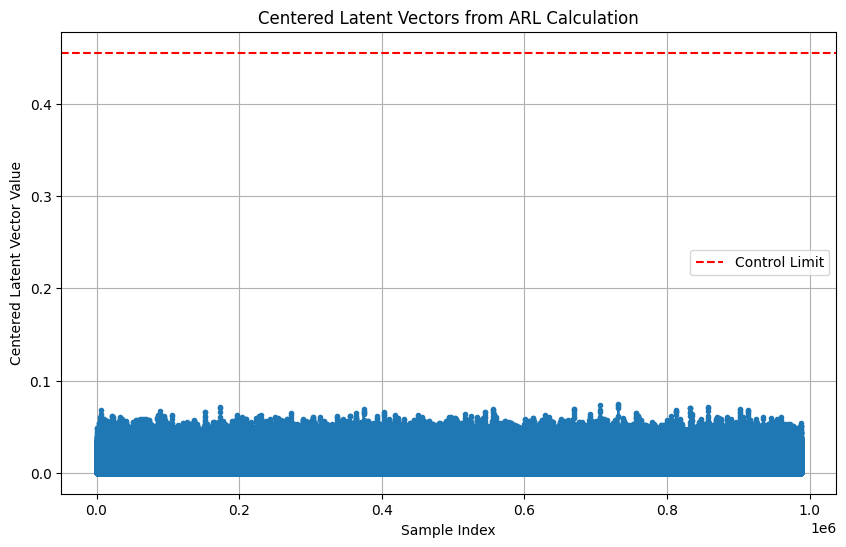

988.0

In [55]:
arl(ar = 0.25, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 0.4555)